In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

import yfinance as yf


from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.seasonal import seasonal_decompose

nvda = yf.Ticker("NVDA")
df = nvda.history(start="2020-01-01")
#df.head()

df = df.asfreq('b')
df = df.ffill()
df.index = df.index.tz_convert(None)

series = df.Close

# Use statsmodels to decompose
period = 7

#size = int(len(series) * 0.8)
size = 830
print('size: ',size)
train, test = series[:size], series[size:size+50]

#exponential smoothing
expo = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=period, initialization_method="estimated")
results_expo = expo.fit()
#results_expo.summary()
results_expo.predict(start=test.index[0], end=test.index[-1])

size:  830


2023-03-09 05:00:00    241.712060
2023-03-10 05:00:00    241.015417
2023-03-13 05:00:00    241.448432
2023-03-14 05:00:00    242.205887
2023-03-15 05:00:00    241.610021
2023-03-16 05:00:00    242.662697
2023-03-17 05:00:00    242.954167
2023-03-20 05:00:00    243.234858
2023-03-21 05:00:00    242.538215
2023-03-22 05:00:00    242.971230
2023-03-23 05:00:00    243.728685
2023-03-24 05:00:00    243.132818
2023-03-27 05:00:00    244.185495
2023-03-28 05:00:00    244.476965
2023-03-29 05:00:00    244.757656
2023-03-30 05:00:00    244.061013
2023-03-31 05:00:00    244.494028
2023-04-03 05:00:00    245.251482
2023-04-04 05:00:00    244.655616
2023-04-05 05:00:00    245.708293
2023-04-06 05:00:00    245.999763
2023-04-07 05:00:00    246.280454
2023-04-10 05:00:00    245.583811
2023-04-11 05:00:00    246.016826
2023-04-12 05:00:00    246.774280
2023-04-13 05:00:00    246.178414
2023-04-14 05:00:00    247.231090
2023-04-17 05:00:00    247.522560
2023-04-18 05:00:00    247.803252
2023-04-19 05:

In [35]:
train.head(10)

Date
2020-01-02 05:00:00    59.744045
2020-01-03 05:00:00    58.787777
2020-01-06 05:00:00    59.034321
2020-01-07 05:00:00    59.749020
2020-01-08 05:00:00    59.861088
2020-01-09 05:00:00    60.518513
2020-01-10 05:00:00    60.842251
2020-01-13 05:00:00    62.749794
2020-01-14 05:00:00    61.579376
2020-01-15 05:00:00    61.153538
Freq: B, Name: Close, dtype: float64

In [36]:
a=results_expo.predict(start=test.index[0], end=test.index[-1])

In [37]:
test.head(10)

Date
2023-03-09 05:00:00    234.295853
2023-03-10 05:00:00    229.587128
2023-03-13 04:00:00    229.597137
2023-03-14 04:00:00    240.564133
2023-03-15 04:00:00    242.213669
2023-03-16 04:00:00    255.340088
2023-03-17 04:00:00    257.179596
2023-03-20 04:00:00    258.929108
2023-03-21 04:00:00    261.918274
2023-03-22 04:00:00    264.607574
Freq: B, Name: Close, dtype: float64

In [38]:
def bollinger(df, window=20, std=1.9):
    rolling_mean = df.rolling(window=window).mean()
    rolling_std = df.rolling(window=window).std()

    upper_band = rolling_mean + (rolling_std*std)
    lower_band = rolling_mean - (rolling_std*std)

    return rolling_mean, upper_band, lower_band

In [39]:
rolling_mean, upper_band, lower_band = bollinger(test)

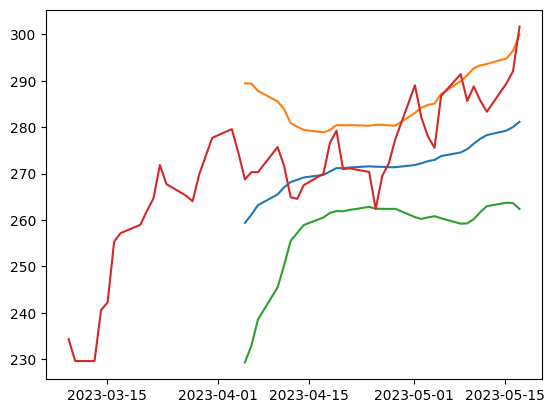

In [40]:
plt.plot(rolling_mean)
plt.plot(upper_band)
plt.plot(lower_band)
plt.plot(test)

In [41]:
df_bollinger = pd.concat([test, rolling_mean, upper_band, lower_band], axis=1)
df_bollinger.columns = ['Price', 'Rolling Mean', 'Upper Band', 'Lower Band']

#
# buy/hold/sell conditions based on bollinger bands
conditions = [
    (df_bollinger['Price'] <= df_bollinger['Lower Band']),
    (df_bollinger['Price'] > df_bollinger['Lower Band']) & (df_bollinger['Price'] < df_bollinger['Upper Band']),
    (df_bollinger['Price'] >=  df_bollinger['Upper Band'])
    ]

# create action list for each condition
action = ['buy', 'hold', 'sell']

# create a new column and use np.select to assign values to it using our lists as arguments
df_bollinger['action'] = np.select(conditions, action)

# display updated DataFrame
df.head()
df_bollinger

,Price,Rolling Mean,Upper Band,Lower Band,action
Date,,,,,
2023-03-09 05:00:00,234.295853,NaN,NaN,NaN,0
2023-03-10 05:00:00,229.587128,NaN,NaN,NaN,0
2023-03-13 04:00:00,229.597137,NaN,NaN,NaN,0
2023-03-14 04:00:00,240.564133,NaN,NaN,NaN,0
2023-03-15 04:00:00,242.213669,NaN,NaN,NaN,0
2023-03-16 04:00:00,255.340088,NaN,NaN,NaN,0
2023-03-17 04:00:00,257.179596,NaN,NaN,NaN,0
2023-03-20 04:00:00,258.929108,NaN,NaN,NaN,0
2023-03-21 04:00:00,261.918274,NaN,NaN,NaN,0


From Bollinger band, it would buy when price is lower than lower band on 2023-04-25 at price = 262.338165, and sell when the price is higher than upper band on 2023-05-01 at price = 289.020874. This would mean a profit of 10%

In [49]:
a.head(10)

2023-03-09 05:00:00    241.712060
2023-03-10 05:00:00    241.015417
2023-03-13 05:00:00    241.448432
2023-03-14 05:00:00    242.205887
2023-03-15 05:00:00    241.610021
2023-03-16 05:00:00    242.662697
2023-03-17 05:00:00    242.954167
2023-03-20 05:00:00    243.234858
2023-03-21 05:00:00    242.538215
2023-03-22 05:00:00    242.971230
Freq: B, dtype: float64

In [65]:
#strategy 1: buy at min, sell at max
def profit_minmax(df_in):
  MAX=df_in.max()
  MIN=df_in.min()
  for i in range(len(df_in)):
    if df_in[i] == MAX:
     MAX_p = i
    if df_in[i] == MIN:
     MIN_p = i
  print('max: ',MAX,' at: ',MAX_p, '; min: ',MIN,' at: ',MIN_p)
  print('Profit: ',(test[MAX_p]/test[MIN_p]-1)*100.,' percent')

profit_minmax(a)

max:  252.37164530416794  at:  49 ; min:  241.01541726730565  at:  1
Profit:  31.4086818604697  percent


In [72]:
#strategy 2: buy at local minimum, sell at local maximum
def profit_continuous(df_in):
  buy=0
  sell=0
  buy_price=0
  sell_price=0
  profit=1.
  if df_in[1] > df_in[0]:
   buy = 1
   buy_price=test[0]
  else:
   sell = 1
   sell_price=test[0]
  for i in range(1,len(df_in)-1):
   if buy == 1:
     if df_in[i+1] < df_in[i]:
        buy = 0
        sell = 1
        sell_price=test[i]
        profit = profit * sell_price/buy_price
   else:
     if df_in[i+1] > df_in[i]:
       sell = 0
       buy = 1
       buy_price=test[i]
       profit = profit * sell_price/buy_price
  print('profit: ',(profit-1)*100,' percent')

profit_continuous(a)


profit:  25.80131079169441  percent


From Exponential smoothing, I compare two strategies:
1. buy at global minimum, sell at global maximum, the profit is 31.4%
2. buy at local minimum, sell at local maximum, repeat for the entire test set period, the profit is 25.8%